# NicheCompass Multimodal Tutorial

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 18.05.2023
- **Date of Last Modification:** 26.06.2023

In this tutorial, we apply NicheCompass to a single multimodal sample (postnatal day 22 coronal section) of a spatial ATAC-RNA-seq mouse brain dataset from [Zhang, D. et al. Spatial epigenome–transcriptome co-profiling of mammalian tissues. Nature 1–10 (2023)](https://www.nature.com/articles/s41586-023-05795-1).

The sample has:
- 9215 observations at spot resolution with spot rna cluster and atac cluster annotations
- 22,914 probed genes
- 121,068 called peaks

- Check the repository [README.md](https://github.com/sebastianbirk/nichecompass#installation) for NicheCompass installation instructions.
- The data for this tutorial can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/data/spatial_omics/```.
    - spatial_atac_rna_seq_mouse_brain_atac.h5ad
    - spatial_atac_rna_seq_mouse_brain.h5ad
- A pretrained model to run only the analysis can be downloaded from [OneDrive](https://1drv.ms/f/s!Atya0VClQocLgvRFj0hYrFICVi0C2w?e=2uLfVX). It has to be stored under ```<repository_root>/artifacts/multimodal/<timestamp>/model/```.
    - 02062023_151955

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import warnings
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import squidpy as sq
from matplotlib import gridspec

from nichecompass.models import NicheCompass
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                add_multimodal_mask_to_adata,
                                aggregate_obsp_matrix_per_cell_type,
                                create_cell_type_chord_plot_from_df,
                                create_new_color_dict,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps,
                                get_gene_annotations,
                                generate_enriched_gp_info_plots,
                                generate_multimodal_pairing_dict,
                                get_unique_genes_from_gp_dict)

/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/aih/sebastian.birk/miniconda3/envs/nichecompass-reproducibility/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/h

### 1.2 Define Parameters

In [45]:
### Dataset ###
dataset = "spatial_atac_rna_seq_mouse_brain"
species = "mouse"
spatial_key = "spatial"
n_neighbors = 8
n_sampled_neighbors = 4
filter_genes = True
n_hvg = 3000
filter_peaks = True
min_cell_peak_thresh_ratio = 0.0005 # 0.05%

### Model ###
# AnnData keys
counts_key = "counts"
adj_key = "spatial_connectivities"
gp_names_key = "nichecompass_gp_names"
active_gp_names_key = "nichecompass_active_gp_names"
gp_targets_mask_key = "nichecompass_gp_targets"
gp_targets_categories_mask_key = "nichecompass_gp_targets_categories"
gp_sources_mask_key = "nichecompass_gp_sources"
gp_sources_categories_mask_key = "nichecompass_gp_sources_categories"
latent_key = "nichecompass_latent"

# Architecture
active_gp_thresh_ratio = 0.05
node_label_method = "one-hop-norm" # one-hop-attention

# Trainer
n_epochs = 400
n_epochs_all_gps = 25
lr = 0.001
lambda_edge_recon = 500000.
lambda_gene_expr_recon = 300.
lambda_chrom_access_recon = 100.
lambda_l1_masked = 5.
l1_targets_categories = ["target_gene"] # targets categories to which l1 regularization will be applied
l1_sources_categories = ["enzyme"] # sources categories to which l1 regularization will be applied
edge_batch_size = 4096 # reduce if not enough memory
use_cuda_if_available = True

### Analysis ###
rna_cluster_key = "RNA_clusters"
atac_cluster_key = "ATAC_clusters"
latent_leiden_resolution = 0.6
latent_cluster_key = f"latent_leiden_{str(latent_leiden_resolution)}"
sample_key = "batch"
spot_size = 30
agg_weights_key = "agg_weights"
differential_gp_test_results_key = "nichecompass_differential_gp_test_results"

### 1.3 Run Notebook Setup

In [4]:
warnings.filterwarnings("ignore")

In [63]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths

In [64]:
# Define paths
ga_data_folder_path = "../data/gene_annotations"
gp_data_folder_path = "../data/gene_programs"
so_data_folder_path = "../data/spatial_omics"
omnipath_lr_network_file_path = f"{gp_data_folder_path}/omnipath_lr_network.csv"
nichenet_lr_network_file_path = f"{gp_data_folder_path}/nichenet_lr_network_v2_{species}.csv"
nichenet_ligand_target_matrix_file_path = f"{gp_data_folder_path}/nichenet_ligand_target_matrix_v2_{species}.csv"
mebocost_enzyme_sensor_interactions_folder_path = f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps"
marker_gp_folder_path = f"{gp_data_folder_path}/marker_gps"
gene_orthologs_mapping_file_path = f"{ga_data_folder_path}/human_mouse_gene_orthologs.csv"
gtf_file_path = f"{ga_data_folder_path}/gencode.vM25.chr_patch_hapl_scaff.annotation.gtf.gz"
artifacts_folder_path = f"../artifacts"
model_folder_path = f"{artifacts_folder_path}/multimodal/{current_timestamp}/model"

## 2. Model Preparation

### 2.1 Create Prior Knowledge Cell-Cell-Interaction (CCI) Gene Program (GP) Mask

- NicheCompass expects a prior CCI GP mask as input, which it will use to make its latent embedding interpretable (through a linear masked decoder). 
- The user can provide a custom GP mask to NicheCompass based on the dataset, application, and hypothesis of interest.
- As a default, we create a GP mask based on three databases of prior CCI knowledge:
    - OmniPath
    - NicheNet
    - MEBOCOST

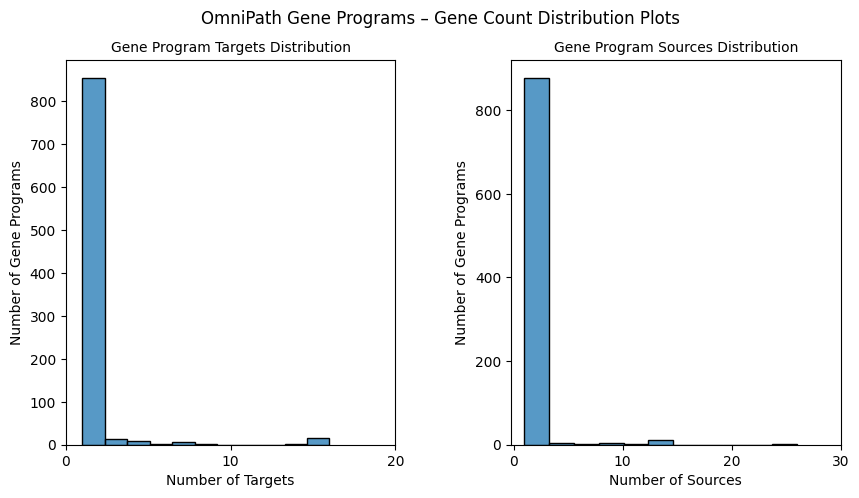

In [7]:
# Retrieve OmniPath GPs (source: ligand gene; target: receptor gene)
omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
    species=species,
    min_curation_effort=0,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=omnipath_lr_network_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from OmniPath GPs to keep
# those genes when filtering
omnipath_genes = get_unique_genes_from_gp_dict(
    gp_dict=omnipath_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [8]:
# Display example OmniPath GPs
for i, (key, value) in enumerate(omnipath_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

BDNF_ligand_receptor_GP {'sources': ['Bdnf'], 'targets': ['Drd4'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}
EPOR_ligand_receptor_GP {'sources': ['Epor'], 'targets': ['Stat3'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}
FYN_ligand_receptor_GP {'sources': ['Fyn'], 'targets': ['Mapk7'], 'sources_categories': ['ligand'], 'targets_categories': ['receptor']}


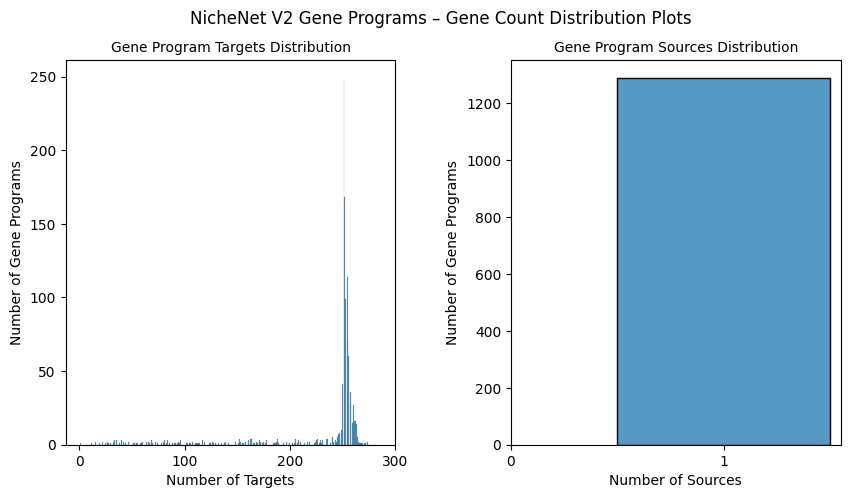

In [9]:
# Retrieve NicheNet GPs (source: ligand gene; target: target genes)
nichenet_gp_dict = extract_gp_dict_from_nichenet_lrt_interactions(
    species=species,
    version="v2",
    keep_target_genes_ratio=0.1,
    max_n_target_genes_per_gp=250,
    load_from_disk=True,
    save_to_disk=True,
    lr_network_file_path=nichenet_lr_network_file_path,
    ligand_target_matrix_file_path=nichenet_ligand_target_matrix_file_path,
    gene_orthologs_mapping_file_path=gene_orthologs_mapping_file_path,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source genes from NicheNet GPs to keep
# those genes when filtering
nichenet_source_genes = get_unique_genes_from_gp_dict(
    gp_dict=nichenet_gp_dict,
    retrieved_gene_entities=["sources"])

In [10]:
# Display example NicheNet GPs
for i, (key, value) in enumerate(nichenet_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

2300002M23Rik_ligand_receptor_target_gene_GP {'sources': ['2300002M23Rik'], 'targets': ['Ddr1', 'Adm', 'Angptl4', 'App', 'Ar', 'Ass1', 'Atf3', 'Bax', 'Bcl2', 'Bcl2l1', 'Bcl3', 'Bcl6', 'Bdnf', 'Bhlhe40', 'Birc3', 'Birc5', 'Bmp4', 'Bnip3l', 'Bnip3l-ps', 'Brca1', 'Btg2', 'Cav1', 'Cbx5', 'Ccl12', 'Ccl20', 'Ccl5', 'Ccn1', 'Ccn2', 'Ccna2', 'Ccnb1', 'Ccnb1-ps', 'Ccnd1', 'Ccnd2', 'Cd5l', 'Cdc6', 'Cdh1', 'Cdk1', 'Cdk6', 'Cdkn1a', 'Cdkn1b', 'Cdkn2c', 'Cebpa', 'Cflar', 'Cited2', 'Csf2', 'Cxcr4', 'Cyp1a1', 'Cyp1b1', 'Cyp24a1', 'Cyp3a13', 'Ddit3', 'Ddit4', 'Dhrs3', 'Dkk1', 'Dtl', 'Dusp1', 'Dusp6', 'E2f1', 'E2f3', 'Edn1', 'Egfr', 'Egr1', 'Egr2', 'Epha2', 'Esr1', 'Etfb', 'Fas', 'Fkbp5', 'Fn1', 'Fos', 'Fosl1', 'Fst', 'Gadd45a', 'Gadd45b', 'Gadd45g', 'Gdf15', 'Gm40460', 'Gm4559', 'Gm45618', 'H2bc14', 'H3f3b', 'H4c12', 'Hes1', 'Hmox1', 'Hnrnpr', 'Icam1', 'Id1', 'Id2', 'Id3', 'Ier3', 'Ifi204', 'Ifi205', 'Ifi211', 'Ifit1bl1', 'Ifit1bl2', 'Igfbp3', 'Il10', 'Il1b', 'Il6', 'Irf1', 'Itpr1', 'Jun', 'Junb', 'Kl

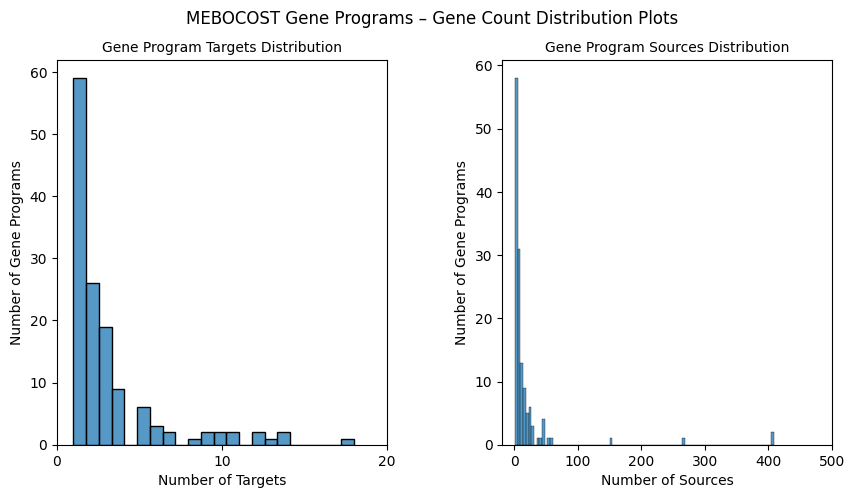

In [11]:
# Retrieve MEBOCOST GPs (source: enzyme genes; target: sensor genes)
mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
    dir_path=mebocost_enzyme_sensor_interactions_folder_path,
    species=species,
    plot_gp_gene_count_distributions=True)

# Retrieve unique source and target genes from MEBOCOST GPs to keep
# those genes when filtering
mebocost_genes = get_unique_genes_from_gp_dict(
    gp_dict=mebocost_gp_dict,
    retrieved_gene_entities=["sources", "targets"])

In [12]:
# Display example MEBOCOST GPs
for i, (key, value) in enumerate(mebocost_gp_dict.items()):
    if i > 2:
        break
    print(key, value)

Deoxyuridine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Pnp', 'Pnp2', 'Tk1', 'Tk2', 'Tymp'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Slc29a2'], 'targets_categories': ['sensor']}
Deoxycytidine_metabolite_enzyme_sensor_GP {'sources': ['Cda', 'Dck', 'Nt5c', 'Nt5c1a', 'Nt5c1b', 'Nt5c2', 'Nt5e', 'Nt5m'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme', 'enzyme'], 'targets': ['Slc29a2'], 'targets_categories': ['sensor']}
3-Methoxytyramine_metabolite_enzyme_sensor_GP {'sources': ['Comt', 'Maoa', 'Maob'], 'sources_categories': ['enzyme', 'enzyme', 'enzyme'], 'targets': ['Taar1'], 'targets_categories': ['sensor']}


In [13]:
# Add GPs into one combined dictionary
# for model training
combined_gp_dict = dict(omnipath_gp_dict)
combined_gp_dict.update(nichenet_gp_dict)
combined_gp_dict.update(mebocost_gp_dict)

In [14]:
# Filter and combine GPs to avoid overlaps
combined_new_gp_dict = filter_and_combine_gp_dict_gps(
    gp_dict=combined_gp_dict,
    gp_filter_mode="subset",
    combine_overlap_gps=True,
    overlap_thresh_source_genes=0.9,
    overlap_thresh_target_genes=0.9,
    overlap_thresh_genes=0.9)

print("Number of gene programs before filtering and combining: "
      f"{len(combined_gp_dict)}.")
print(f"Number of gene programs after filtering and combining: "
      f"{len(combined_new_gp_dict)}.")

Number of gene programs before filtering and combining: 2324.
Number of gene programs after filtering and combining: 1818.


### 2.2 Load Data & Compute Spatial Neighbor Graph

- NicheCompass expects a precomputed spatial adjacency matrix stored in 'adata.obsp[adj_key]'.
- The user can customize the spatial neighbor graph construction based on the dataset, application, and hypothesis of interest.
- In the multimodal setting, we will provide one adata object per modality to NicheCompass.

In [15]:
# Read data
adata = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}.h5ad")
adata_atac = sc.read_h5ad(
        f"{so_data_folder_path}/{dataset}_atac.h5ad")

In [16]:
# Compute (separate) spatial neighborhood graphs
sq.gr.spatial_neighbors(adata,
                        coord_type="generic",
                        spatial_key=spatial_key,
                        n_neighs=n_neighbors)

# Make adjacency matrix symmetric
adata.obsp[adj_key] = (
    adata.obsp[adj_key].maximum(
        adata.obsp[adj_key].T))

### 2.3 Filter Genes & Peaks

In [17]:
if filter_genes:
    print("Filtering genes...")
    # Filter genes and only keep ligand, receptor, metabolite enzyme, 
    # metabolite sensor and the 'n_hvg' highly variable genes (potential target
    # genes of nichenet)
    gp_dict_genes = get_unique_genes_from_gp_dict(
        gp_dict=combined_new_gp_dict,
            retrieved_gene_entities=["sources", "targets"])
    print(f"Starting with {len(adata.var_names)} genes.")
    sc.pp.filter_genes(adata,
                       min_cells=0)
    print(f"Keeping {len(adata.var_names)} genes after filtering genes with "
          "expression in 0 cells.")

    sc.pp.highly_variable_genes(
        adata,
        layer=counts_key,
        n_top_genes=n_hvg,
        flavor="seurat_v3",
        subset=False)

    # Get gene program relevant genes
    gp_relevant_genes = list(set(omnipath_genes + 
                                 nichenet_source_genes + 
                                 mebocost_genes))
    
    adata.var["gp_relevant"] = (
        adata.var.index.str.upper().isin(gp_relevant_genes))
    adata.var["keep_gene"] = (adata.var["gp_relevant"] | 
                              adata.var["highly_variable"])
    adata = adata[:, adata.var["keep_gene"] == True]
    print(f"Keeping {len(adata.var_names)} highly variable or gene program "
          "relevant genes.")
    #adata = (adata[:, adata.var_names[adata.var_names.str.upper().isin(
    #            [gene.upper() for gene in gp_dict_genes])].sort_values()])
    #print(f"Keeping {len(adata.var_names)} genes after filtering genes not in "
    #      "gp dict.")
    
if filter_peaks:
    print("\nFiltering peaks...")
    print(f"Starting with {len(adata_atac.var_names)} peaks.")
    # Filter out peaks that are rarely detected to reduce GPU footprint of model
    min_cells = int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)
    sc.pp.filter_genes(adata_atac, min_cells=min_cells)
    print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
          f"counts in less than {int(adata_atac.shape[0] * min_cell_peak_thresh_ratio)} cells.")

Filtering genes...
Starting with 22914 genes.
Keeping 22914 genes after filtering genes with expression in 0 cells.
Keeping 3011 highly variable or gene program relevant genes.

Filtering peaks...
Starting with 121068 peaks.
Keeping 121068 peaks after filtering peaks with counts in less than 4 cells.


### 2.4 Annotate Genes & Peaks

Next, we will add positional annotations to genes and peaks to be able to match spatially proximal peaks to genes.

In [18]:
adata, adata_atac = get_gene_annotations(
    adata=adata,
    adata_atac=adata_atac,
    gtf_file_path=gtf_file_path)

In [19]:
# Display gene annotations
adata.var[["chrom", "chromStart", "chromEnd"]]

,chrom,chromStart,chromEnd
Ppp1r14c,chr10,3366056.0,3464975.0
Ccdc170,chr10,4482501.0,4562231.0
Gm25694,chr10,5036174.0,5036456.0
Vip,chr10,5639217.0,5647617.0
Cnksr3,chr10,7119062.0,7212237.0
...,...,...,...
Prps2,chrX,167346321.0,167382749.0
Msl3,chrX,168654116.0,168673898.0
Arhgap6,chrX,168795098.0,169304435.0
Erdr1,chrX,170009658.0,170019281.0


In [20]:
# Display peak annotations
adata_atac.var[["chrom", "chromStart", "chromEnd"]]

,chrom,chromStart,chromEnd
chr1:3094734-3095650,chr1,3094734,3095650
chr1:3119757-3120179,chr1,3119757,3120179
chr1:3120267-3120653,chr1,3120267,3120653
chr1:3121314-3122051,chr1,3121314,3122051
chr1:3264998-3265766,chr1,3264998,3265766
...,...,...,...
GL456216.1:31908-32576,GL456216.1,31908,32576
GL456216.1:43983-44510,GL456216.1,43983,44510
GL456216.1:48771-49683,GL456216.1,48771,49683
JH584292.1:12571-13497,JH584292.1,12571,13497


### 2.5 Add GP Mask to Data

In [21]:
# Add the GP dictionary as binary masks to the adata
add_gps_from_gp_dict_to_adata(
    gp_dict=combined_new_gp_dict,
    adata=adata,
    gp_targets_mask_key=gp_targets_mask_key,
    gp_targets_categories_mask_key=gp_targets_categories_mask_key,
    gp_sources_mask_key=gp_sources_mask_key,
    gp_sources_categories_mask_key=gp_sources_categories_mask_key,
    gp_names_key=gp_names_key,
    min_genes_per_gp=1,
    min_source_genes_per_gp=0,
    min_target_genes_per_gp=0,
    max_genes_per_gp=None,
    max_source_genes_per_gp=None,
    max_target_genes_per_gp=None)

### 2.6 Add Chromatin Accessibility Mask to Data

Based on spatial proximity to the genes in the GP mask, we will add a chromatin accessibility mask.

In [22]:
gene_peak_dict = generate_multimodal_pairing_dict(
    adata,
    adata_atac)

window_graph:   0%|          | 0/2727 [00:00<?, ?it/s]

In [23]:
adata, adata_atac = add_multimodal_mask_to_adata(
    adata=adata,
    adata_atac=adata_atac,
    gene_peak_mapping_dict=gene_peak_dict)

print(f"Keeping {len(adata_atac.var_names)} peaks after filtering peaks with "
      "no matching genes in gp mask.")

Keeping 13509 peaks after filtering peaks with no matching genes in gp mask.


### 2.7 Explore Data

In [24]:
rna_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=rna_cluster_key)

atac_cluster_colors = create_new_color_dict(
    adata=adata,
    cat_key=atac_cluster_key)

Number of nodes (observations): 9215
Number of gene node features: 2727
Number of peak node features: 13509


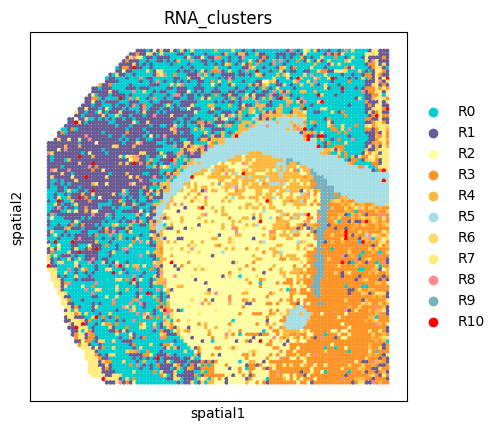

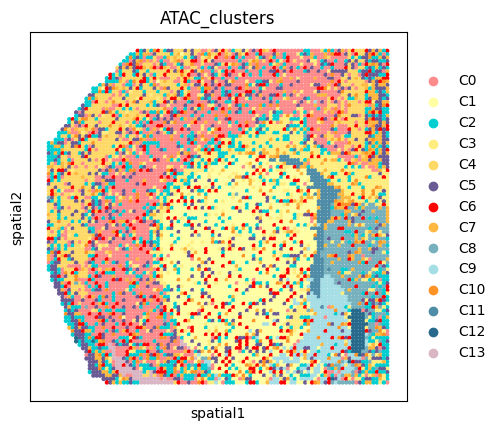

In [25]:
print(f"Number of nodes (observations): {adata.layers['counts'].shape[0]}")
print(f"Number of gene node features: {adata.layers['counts'].shape[1]}")
print(f"Number of peak node features: {adata_atac.layers['counts'].shape[1]}")

# Visualize spot-level annotated data in physical space
sc.pl.spatial(adata,
              color=rna_cluster_key,
              palette=rna_cluster_colors,
              spot_size=spot_size)
sc.pl.spatial(adata_atac,
              color=atac_cluster_key,
              palette=atac_cluster_colors,
              spot_size=spot_size) 

## 3. Model Training

### 3.1 Initialize, Train & Save Model

In [82]:
active_gp_thresh_ratio = 0.
lambda_l1_masked = 10.
lambda_edge_recon = 1000000.
lambda_chrom_access_recon = 0.

In [83]:
# Initialize model
model = NicheCompass(adata,
                     adata_atac,
                     counts_key=counts_key,
                     adj_key=adj_key,
                     gp_names_key=gp_names_key,
                     active_gp_names_key=active_gp_names_key,
                     gp_targets_mask_key=gp_targets_mask_key,
                     gp_targets_categories_mask_key=gp_targets_categories_mask_key,
                     gp_sources_mask_key=gp_sources_mask_key,
                     gp_sources_categories_mask_key=gp_sources_categories_mask_key,
                     latent_key=latent_key,
                     active_gp_thresh_ratio=active_gp_thresh_ratio,
                     node_label_method=node_label_method)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb, include_chrom_access_recon_loss: True, chrom_access_recon_dist: nb 
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.0
LOG VARIATIONAL -> True
ENCODER -> n_input: 16236, n_cat_covariates_embed_input: 0, n_layers: 1, n_hidden: 1454, n_latent: 1454, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1454, n_cat_covariates_embed_input: 0, n_addon_input: 0, n_output: 5454
MASKED CHROMATIN ACCESSIBILITY DECODER -> n_input: 1454, n_cat_covariates_embed_input: 0, n_addon_input: 0, n_output: 27018
ONE HOP GCN NORM NODE LABEL AGGREGATOR


In [ ]:
# Train model
model.train(n_epochs=n_epochs,
            n_epochs_all_gps=n_epochs_all_gps,
            lr=lr,
            lambda_edge_recon=lambda_edge_recon,
            lambda_gene_expr_recon=lambda_gene_expr_recon,
            lambda_chrom_access_recon=lambda_chrom_access_recon,
            lambda_l1_masked=lambda_l1_masked,
            l1_targets_categories=l1_targets_categories,
            l1_sources_categories=l1_sources_categories,
            edge_batch_size=edge_batch_size,
            use_cuda_if_available=use_cuda_if_available,
            loaders_n_direct_neighbors=n_sampled_neighbors,
            verbose=True)


--- INITIALIZING TRAINER ---
Number of training nodes: 8293
Number of validation nodes: 922
Number of training edges: 33399
Number of validation edges: 3711
Edge batch size: 4096
Node batch size: None

--- MODEL TRAINING ---


In [ ]:
# Compute latent neighbor graph
sc.pp.neighbors(model.adata,
                use_rep=latent_key,
                key_added=latent_key)

# Compute UMAP embedding
sc.tl.umap(model.adata,
           neighbors_key=latent_key)

In [ ]:
# Save trained model
model.save(dir_path=model_folder_path,
           overwrite=True,
           save_adata=True,
           adata_file_name="adata.h5ad",
           save_adata_atac=True,
           adata_atac_file_name=f"adata_atac.h5ad")

## 4. Analysis

In [71]:
# load_timestamp = "07072023_093643"
load_timestamp = "07072023_103257"

figure_folder_path = f"{artifacts_folder_path}/multimodal/{load_timestamp}/figures"
model_folder_path = f"{artifacts_folder_path}/multimodal/{load_timestamp}/model"

os.makedirs(figure_folder_path, exist_ok=True)

In [72]:
# Load trained model
model = NicheCompass.load(dir_path=model_folder_path,
                          adata=None,
                          adata_file_name="adata.h5ad",
                          adata_atac=None,
                          adata_atac_file_name="adata_atac.h5ad",
                          gp_names_key=gp_names_key)

--- INITIALIZING NEW NETWORK MODULE: VARIATIONAL GENE PROGRAM GRAPH AUTOENCODER ---
LOSS -> include_edge_recon_loss: True, include_gene_expr_recon_loss: True, gene_expr_recon_dist: nb, include_chrom_access_recon_loss: True, chrom_access_recon_dist: nb 
NODE LABEL METHOD -> one-hop-norm
ACTIVE GP THRESHOLD RATIO -> 0.0
LOG VARIATIONAL -> True
ENCODER -> n_input: 16236, n_cat_covariates_embed_input: 0, n_layers: 1, n_hidden: 1454, n_latent: 1454, n_addon_latent: 0, conv_layer: gcnconv, n_attention_heads: 0, dropout_rate: 0.0
COSINE SIM GRAPH DECODER -> dropout_rate: 0.0
MASKED GENE EXPRESSION DECODER -> n_input: 1454, n_cat_covariates_embed_input: 0, n_addon_input: 0, n_output: 5454
MASKED CHROMATIN ACCESSIBILITY DECODER -> n_input: 1454, n_cat_covariates_embed_input: 0, n_addon_input: 0, n_output: 27018
ONE HOP GCN NORM NODE LABEL AGGREGATOR


In [73]:
summary_df = model.get_gp_summary()

In [74]:
summary_df["n_non_zero_target_genes"].sum()

7063

In [75]:
summary_df["n_target_genes"].sum()

30713

In [76]:
samples = model.adata.obs[sample_key].unique().tolist()

### 4.1 Visualize NicheCompass Embeddings

Let's look at the preservation of rna cluster and atac cluster spot annotations in the embedding space. Note that the goal of NicheCompass is not a perfect separation of rna cluster or atac cluster spot annotations but rather to identify spatial cellular niches. Nevertheless, it can be useful to look at the spot annotations if available.

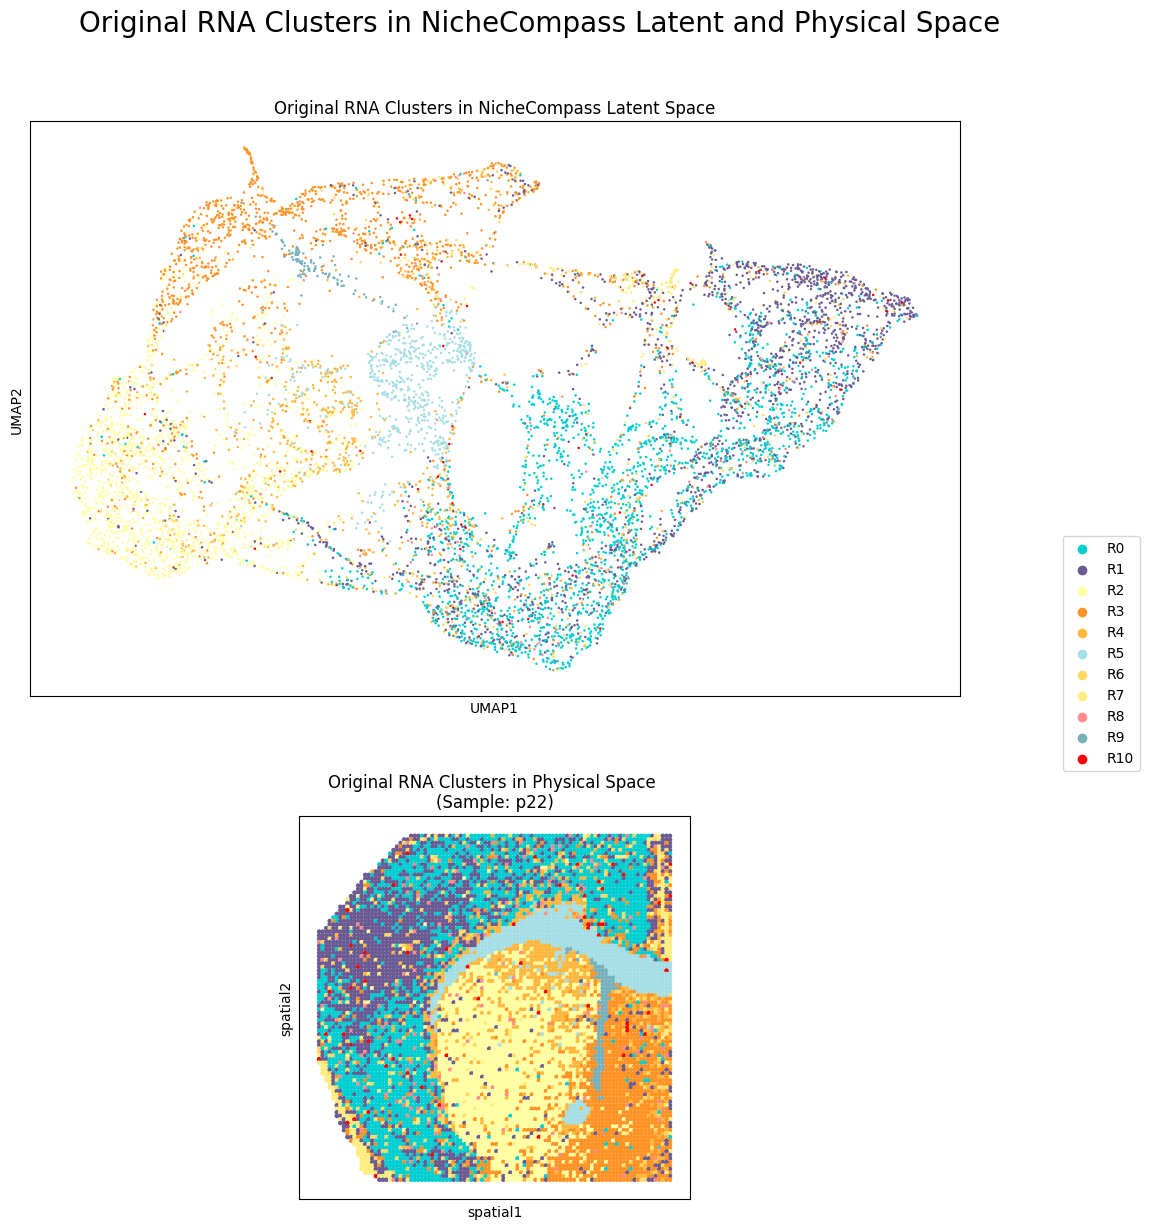

In [77]:
# Create plot of RNA cluster annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["R0"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            "rna_clusters_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Original RNA Clusters " \
                       "in NicheCompass Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[rna_cluster_key],
           groups=groups,
           palette=rna_cluster_colors,
           title=f"Original RNA Clusters in NicheCompass Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[rna_cluster_key],
                  groups=groups,
                  palette=rna_cluster_colors,
                  spot_size=spot_size,
                  title=f"Original RNA Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

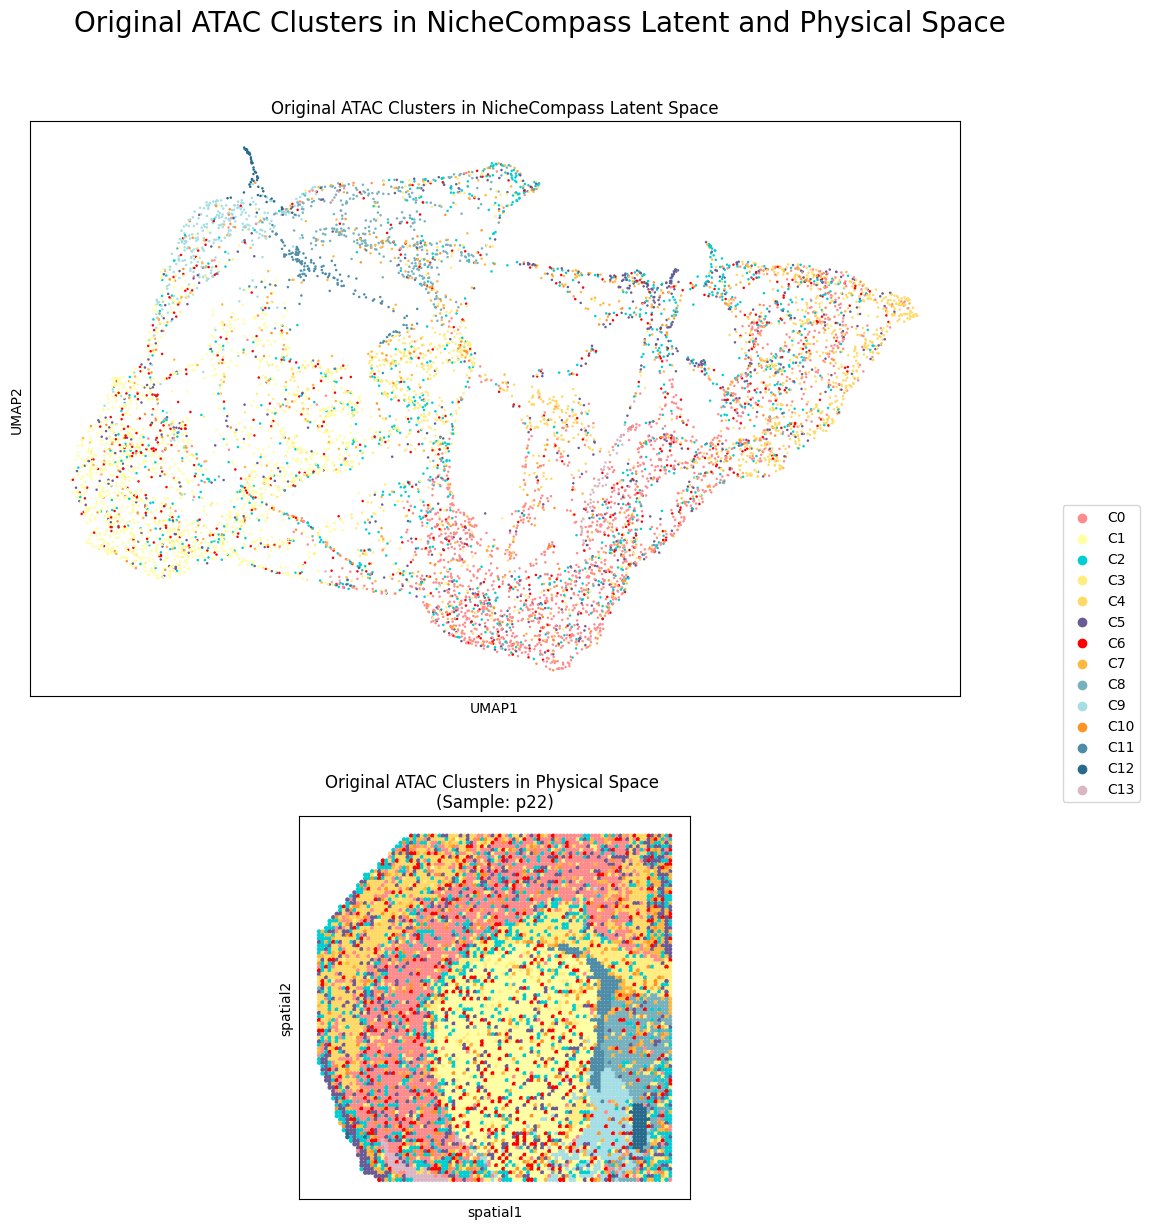

In [78]:
# Create plot of ATAC cluster annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["C0"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            "atac_clusters_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"Original ATAC Clusters " \
                       "in NicheCompass Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[atac_cluster_key],
           groups=groups,
           palette=atac_cluster_colors,
           title=f"Original ATAC Clusters in NicheCompass Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[atac_cluster_key],
                  groups=groups,
                  palette=atac_cluster_colors,
                  spot_size=spot_size,
                  title=f"Original ATAC Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.2 Identify Niches

We will compute Leiden clustering based on the NicheCompass embeddings to identify spatial cellular niches.

In [79]:
# Compute latent Leiden clustering
sc.tl.leiden(adata=model.adata,
             resolution=latent_leiden_resolution,
             key_added=latent_cluster_key,
             neighbors_key=latent_key)

In [80]:
latent_cluster_colors = create_new_color_dict(
    adata=model.adata,
    cat_key=latent_cluster_key)

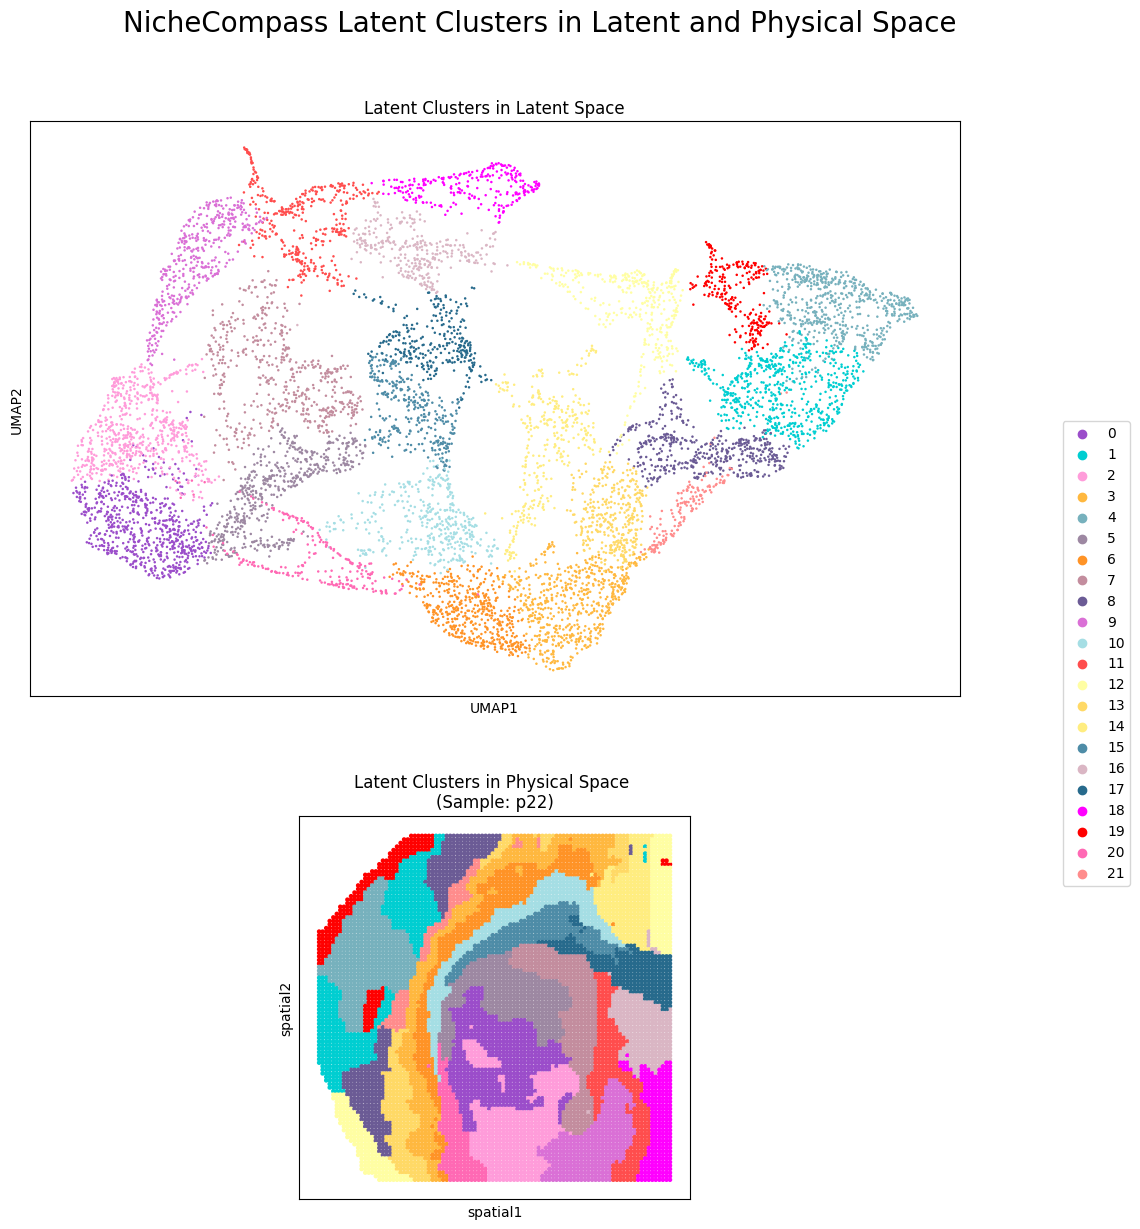

In [81]:
# Create plot of latent cluster / niche annotations in physical and latent space
groups = None # set this to a specific cluster for easy visualization, e.g. ["11"]
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            "latent_clusters_latent_physical_space.svg"

fig = plt.figure(figsize=(12, 14))
title = fig.suptitle(t=f"NicheCompass Latent Clusters " \
                       "in Latent and Physical Space",
                     y=0.96,
                     x=0.55,
                     fontsize=20)
spec1 = gridspec.GridSpec(ncols=1,
                          nrows=2,
                          width_ratios=[1],
                          height_ratios=[3, 2])
spec2 = gridspec.GridSpec(ncols=len(samples),
                          nrows=2,
                          width_ratios=[1] * len(samples),
                          height_ratios=[3, 2])
axs = []
axs.append(fig.add_subplot(spec1[0]))
sc.pl.umap(adata=model.adata,
           color=[latent_cluster_key],
           groups=groups,
           palette=latent_cluster_colors,
           title=f"Latent Clusters in Latent Space",
           ax=axs[0],
           show=False)
for idx, sample in enumerate(samples):
    axs.append(fig.add_subplot(spec2[len(samples) + idx]))
    sc.pl.spatial(adata=model.adata[model.adata.obs[sample_key] == sample],
                  color=[latent_cluster_key],
                  groups=groups,
                  palette=latent_cluster_colors,
                  spot_size=spot_size,
                  title=f"Latent Clusters in Physical Space \n"
                        f"(Sample: {sample})",
                  legend_loc=None,
                  ax=axs[idx+1],
                  show=False)

# Create and position shared legend
handles, labels = axs[0].get_legend_handles_labels()
lgd = fig.legend(handles,
                 labels,
                 loc="center left",
                 bbox_to_anchor=(0.98, 0.5))
axs[0].get_legend().remove()

# Adjust, save and display plot
plt.subplots_adjust(wspace=0.2, hspace=0.25)
if save_fig:
    fig.savefig(file_path,
                bbox_extra_artists=(lgd, title),
                bbox_inches="tight")
plt.show()

### 4.3 Analyze Niches

#### 4.3.1 Niche Composition

We can analyze the niche composition in terms of rna cluster spot labels.

In [ ]:
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_composition.svg"

df_counts = (model.adata.obs.groupby([latent_cluster_key, rna_cluster_key])
             .size().unstack())
df_counts.plot(kind="bar", stacked=True)
legend = plt.legend(bbox_to_anchor=(1, 1), loc="upper left", prop={'size': 10})
legend.set_title("RNA Cluster", prop={'size': 10})
plt.title("RNA Cluster Composition of Niches")
plt.xlabel("Niche")
plt.ylabel("RNA Cluster Counts")
if save_fig:
    plt.savefig(file_path,
                bbox_extra_artists=(legend,),
                bbox_inches="tight")

#### 4.3.2 Spot Annotation Neighbor Importances

Now we will investigate neighbor importances in terms of rna cluster spot labels of different niches.

In [ ]:
# Retrieve node neighbor importances 
# (aggregation weights of the node label aggregator)
model.adata.obsp[agg_weights_key] = model.get_neighbor_importances()

In [ ]:
# Get cell type neighbor importances for each niche / latent cluster
niche_neighbor_importances_df = aggregate_obsp_matrix_per_cell_type(
    adata=model.adata,
    obsp_key=agg_weights_key,
    cell_type_key=rna_cluster_key,
    group_key=latent_cluster_key,
    agg_rows=True)

In [ ]:
display(niche_neighbor_importances_df)

In [ ]:
# Generate chord plots showing cell type neighbor importances
# for each niche / latent cluster
groups = "all"
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"res_{latent_leiden_resolution}_" \
            f"niche_neighbor_importances.png"

create_cell_type_chord_plot_from_df(
        adata=model.adata,
        df=niche_neighbor_importances_df,
        link_threshold=0.01,
        cell_type_key=rna_cluster_key,
        group_key=latent_cluster_key,
        groups=groups,
        plot_label="Niche",
        save_fig=save_fig,
        file_path=file_path)

### 4.4 Perform Differential Gene Program Testing

Now we can test which communication gene programs are differentially expressed in a niche. To this end, we will perform differential gene program testing of a selected niche, e.g. latent cluster / niche "11" (```selected_cats = ["11"]```) vs all other latent clusters / niches (```comparison_cats = "rest"```). However, differential gene program testing can also be performed in the following ways:
- Set ```selected_cats = None``` to perform differential gene program testing across all niches, as opposed to just for one specific niche.
- Set ```comparison_cats = ["2", "3"]``` to perform differential gene program testing against latent clusters / niches "2" and "3" as opposed to against all other latent clusters / niches.

We choose a log bayes factor threshold of 4.6 to determine decisively enriched gene programs. Alternatively, the threshold could be loosened to a value of 2.3 to also allow "only" strongly enriched gene programs to be identified (see https://en.wikipedia.org/wiki/Bayes_factor).

In [ ]:
# Check number of active GPs
active_gps = model.get_active_gps()
print(f"Number of total gene programs: {len(model.adata.uns[gp_names_key])}.")
print(f"Number of active gene programs: {len(active_gps)}.")

In [ ]:
# Display example active GPs
gp_summary_df = model.get_gp_summary()
gp_summary_df[gp_summary_df["gp_active"] == True].head()

In [ ]:
# Set parameters for differential gp testing
selected_cats = ["11"]
comparison_cats = "rest"
title = f"NicheCompass Latent Cluster Decisively Enriched Gene Programs"
log_bayes_factor_thresh = 4.6 # 2.3
save_fig = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}" \
             "_latent_cluster_11_vs_rest_enriched_gps_dotplot.svg"

In [ ]:
# Run differential gp testing
enriched_gps = model.run_differential_gp_tests(
    cat_key=latent_cluster_key,
    selected_cats=selected_cats,
    comparison_cats=comparison_cats,
    log_bayes_factor_thresh=log_bayes_factor_thresh)

In [ ]:
# Results are stored in a df in the adata object
model.adata.uns[differential_gp_test_results_key]

In [ ]:
# Create dotplot of results
fig = sc.pl.dotplot(model.adata,
                    enriched_gps,
                    groupby=latent_cluster_key,
                    dendrogram=True, 
                    title=title,
                    swap_axes=True,
                    return_fig=True,
                    figsize=(model.adata.obs[latent_cluster_key].nunique() / 2,
                             len(enriched_gps) / 2))
if save_fig:
    fig.savefig(file_path)
else:
    fig.show()

In [ ]:
# Store gene program summary of enriched gene programs
save_file = True
file_path = f"{figure_folder_path}/" \
            f"/log_bayes_factor_{log_bayes_factor_thresh}_" \
            "latent_cluster_11_vs_rest_enriched_gps_summary.csv"

gp_summary_cols = ["gp_name",
                   "n_source_genes",
                   "n_non_zero_source_genes",
                   "n_target_genes",
                   "n_non_zero_target_genes",
                   "gp_source_genes",
                   "gp_target_genes",
                   "gp_source_genes_weights_sign_corrected",
                   "gp_target_genes_weights_sign_corrected",
                   "gp_source_genes_importances",
                   "gp_target_genes_importances",
                   "n_source_peaks",
                   "n_target_peaks",
                   "gp_source_peaks",
                   "gp_target_peaks",
                   "gp_source_peaks_weights_sign_corrected",
                   "gp_target_peaks_weights_sign_corrected",
                   "gp_source_peaks_importances",
                   "gp_target_peaks_importances"]

enriched_gp_summary_df = gp_summary_df[gp_summary_df["gp_name"].isin(enriched_gps)]
cat_dtype = pd.CategoricalDtype(categories=enriched_gps, ordered=True)
enriched_gp_summary_df.loc[:, "gp_name"] = enriched_gp_summary_df["gp_name"].astype(cat_dtype)
enriched_gp_summary_df = enriched_gp_summary_df.sort_values(by="gp_name")
enriched_gp_summary_df = enriched_gp_summary_df[gp_summary_cols]

if save_file:
    enriched_gp_summary_df.to_csv(f"{file_path}")
else:
    display(enriched_gp_summary_df)

### 4.5 Analyze Enriched Gene Programs

Now we will have a look at the gene program scores as well as the (log normalized) count distributions of
the most important omics features of the differentially expressed gene programs.

In [ ]:
plot_label = f"log_bayes_factor_{log_bayes_factor_thresh}_cluster_11_vs_rest"
save_figs = True

generate_enriched_gp_info_plots(
    plot_label=plot_label,
    model=model,
    sample_key=sample_key,
    differential_gp_test_results_key=differential_gp_test_results_key,
    cat_key=latent_cluster_key,
    cat_palette=latent_cluster_colors,
    n_top_enriched_gps=10,
    feature_spaces=samples, # ["latent"]
    n_top_genes_per_gp=3,
    n_top_peaks_per_gp=3,
    log_norm_omics_features=True,
    save_figs=save_figs,
    figure_folder_path=f"{figure_folder_path}/",
    spot_size=spot_size)